#TIME SERIES FORECASTING WITH TENSORFLOW

This notebook is one of those i wrote as practise for the **Tensorflow Certificate Exam**

The Data i used are monthly statements of sunspot from 1749 to 2018 from [Tensorflow Datasets API](https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv).

I tried to predict the last month of the year based on the 11 previous months based on the total sunspots mean number and the months.
The implementation is fully with Tensorflow except Data Processing.

I use three keras models :


1.   One fully Dense Neural Network
2.   One LSTM-DNN Neural Network
3.   One CNN-DNN Neural Network



In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers

In [4]:
def load_data(path='/content/Sunspots.csv', verbose=None):
    df = pd.read_csv(path)
    df = df.drop(['Unnamed: 0'], axis=1)
    if verbose :
        df.plot()
    return df

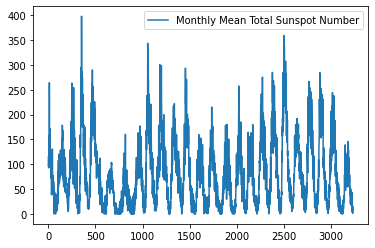

In [5]:
path ='/content/Sunspots.csv'
df = load_data(path,verbose=True)

In [6]:
##Our dataset consist in monthly record of the mean sunspot number 
##3235 data points from 1749-2018-06-30
df.info

<bound method DataFrame.info of             Date  Monthly Mean Total Sunspot Number
0     1749-01-31                               96.7
1     1749-02-28                              104.3
2     1749-03-31                              116.7
3     1749-04-30                               92.8
4     1749-05-31                              141.7
...          ...                                ...
3230  2018-03-31                                2.5
3231  2018-04-30                                8.9
3232  2018-05-31                               13.2
3233  2018-06-30                               15.9
3234  2018-07-31                                1.6

[3235 rows x 2 columns]>

In [7]:
def make_month_feature(series, concat_to_df=True):
    #extract month from 'Date' column
    times = series['Date']
    months = times.apply(lambda x: x.split('-')[1])
    if concat_to_df:
        df = pd.concat([series.drop(['Date'], axis=1), months], axis =1)
        return df
    else:
        return months


In [8]:
def scale_min_max(series):
    mm = MinMaxScaler()
    return mm.fit_transform(series)

In [9]:
def clean_data(series):
    series_filled = series.interpolate(method='linear')
    return series_filled

In [10]:
def split_data(series,train_fraq, test_len=607):
    #slice the last 50 years + 7 monts for testing
    test_slice = len(series) - test_len
    test_data = series[test_slice:]
    train_val_data = series[:test_slice]
    
    #make train and validation
    train_size = int(len(train_val_data) * train_fraq)
    train_data = train_val_data[:train_size]
    valid_data = train_val_data[train_size:]
    
    return train_data , valid_data, test_data
    

In [11]:
def windowed_dataset(series, n_past, n_future,batch_size, shuffle_buffer):
    window = n_past+n_future
    #convert our data to tf.dataset Object
    ds = tf.data.Dataset.from_tensor_slices(series)
    #windowing the dataset and shift by the prediction lenght
    ds = ds.window(window, shift=n_future, drop_remainder=True)
    #flatten the dataset in batch of window_size
    ds = ds.flat_map(lambda x: x.batch(window))
    #shuffle 
    ds = ds.shuffle(shuffle_buffer)
    #set traget and features , x and y
    ds = ds.map(lambda window: (window[:-n_future], window[-n_future:, :1]))
    #batch all tha stuff
    ds = ds.batch(batch_size).prefetch(1)
    return ds


In [19]:
path ='/content/Sunspots.csv'
df = load_data(path,verbose=None)
df = clean_data(df)
df = make_month_feature(df, concat_to_df=True)
#df = scale_min_max(df)
print(df)

#train_df , valid_df , test_df = split_data(df, train_fraq=0.65)
#test = windowed_dataset(train_df,n_past=11,n_future=1,batch_size=142,shuffle_buffer=500)
#df
#print(int(len(train_df)//12), len(valid_df), len(test_df))

      Monthly Mean Total Sunspot Number Date
0                                  96.7   01
1                                 104.3   02
2                                 116.7   03
3                                  92.8   04
4                                 141.7   05
...                                 ...  ...
3230                                2.5   03
3231                                8.9   04
3232                               13.2   05
3233                               15.9   06
3234                                1.6   07

[3235 rows x 2 columns]


In [13]:
def build_dataset(concat_to_df=True,train_fraq=0.65,
                 n_past = 11,
                 n_future =1,
                 batch_size = 142,
                 shuffle_buffer=500,
                 ):
    tf.random.set_seed(42)
    data = load_data()
    data = clean_data(data)
    data = make_month_feature(data)
    data = scale_min_max(data)
    
    train_data , valid_data , test_data = split_data(data,train_fraq)
    
    train_ds = windowed_dataset(train_data, n_past, n_future, batch_size, shuffle_buffer)
    valid_ds = windowed_dataset(valid_data, n_past,n_future,batch_size, shuffle_buffer)
    test_ds  = windowed_dataset(test_data, n_past, n_future, batch_size, shuffle_buffer)
    
    print(f"Prediction lookback (n_past) = {n_past}")
    print(f"Prediction horizon (n_future) = {n_future}")
    print(f"Batch size  (batch_size) = {batch_size}")
    
    return train_ds , valid_ds, test_ds
train_ds, valid_ds, test_ds = build_dataset()

Prediction lookback (n_past) = 11
Prediction horizon (n_future) = 1
Batch size  (batch_size) = 142


In [14]:
def set_params(lr=1e-4, n_past=11,n_future=1,n_features=2):
    lr = lr
    n_past= n_past
    n_future= n_future
    n_features= n_features

    return  n_past, n_future, n_features ,lr
model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):
    Model_Checkpoint = tf.keras.callbacks.ModelCheckpoint('{}/'.format(model_name), save_best_only=True)
    print('Building Dataset......')
    n_past, n_future, n_features,lr  = set_params()
    train_ds, val_ds, test_ds = build_dataset()

    model = model_func(n_past, n_future, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs , callbacks=[Model_Checkpoint])
    
    print(f'Loading Saved {model_name} Model....')
    model_loaded = tf.keras.models.load_model('{}/'.format(model_name))
    print(f'Saving {model_name} Model Configs...')
    model_configs[model_name] = cfg_model_run(model_loaded, model_hist, test_ds)
    return test_ds

In [15]:
def cnn_model(n_past, n_future, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        layers.Conv1D(64, kernel_size=6, input_shape=(n_past,n_features)),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(1),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(n_future)
    ], name='cnn')
    
    loss='mse'
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    return model

cnn = cnn_model(*set_params())
cnn.summary()
    

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0       

In [16]:
def lstm_model(n_past,n_future,n_features,lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        layers.LSTM(72, input_shape=(n_past,n_features), return_sequences = True),
        layers.LSTM(32, activation='relu', return_sequences=False),
        layers.Dropout(0.3),
        layers.Dense(62, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(n_future)
        
    ], name='lstm')
    
    loss='mse'
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    return model

lstm = lstm_model(*set_params())
lstm.summary()
    

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11, 72)            21600     
                                                                 
 lstm_1 (LSTM)               (None, 32)                13440     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 62)                2046      
                                                                 
 dropout_1 (Dropout)         (None, 62)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 63        
                                                                 
Total params: 37,149
Trainable params: 37,149
Non-trainable pa

In [17]:
def dnn_model(n_past,n_future,n_features,lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        layers.Flatten(input_shape=(n_past, n_features)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(n_future)
    ], name='dnn')
    
    loss = 'mse'
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    return model

dnn = dnn_model(*set_params())
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 22)                0         
                                                                 
 dense (Dense)               (None, 128)               2944      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 19,585
Trainable params: 19,585
Non-trainable par

In [23]:
model_configs=dict()
run_model('dnn', dnn_model, model_configs, epochs=100)
run_model('lstm', lstm_model, model_configs, epochs=100)
run_model('cnn', cnn_model, model_configs, epochs=100)

Building Dataset......
Prediction lookback (n_past) = 11
Prediction horizon (n_future) = 1
Batch size  (batch_size) = 142
Epoch 1/100
12/12 [==============================] - 2s 151ms/step - loss: 0.1382 - mae: 0.2983 - val_loss: 0.0746 - val_mae: 0.2161
Epoch 2/100
12/12 [==============================] - 4s 329ms/step - loss: 0.0689 - mae: 0.1991 - val_loss: 0.0306 - val_mae: 0.1313
Epoch 3/100
12/12 [==============================] - 3s 254ms/step - loss: 0.0460 - mae: 0.1680 - val_loss: 0.0206 - val_mae: 0.1140
Epoch 4/100
12/12 [==============================] - 3s 223ms/step - loss: 0.0439 - mae: 0.1664 - val_loss: 0.0174 - val_mae: 0.1065
Epoch 5/100
12/12 [==============================] - 1s 103ms/step - loss: 0.0403 - mae: 0.1578 - val_loss: 0.0150 - val_mae: 0.0972
Epoch 6/100
12/12 [==============================] - 1s 104ms/step - loss: 0.0396 - mae: 0.1554 - val_loss: 0.0133 - val_mae: 0.0896
Epoch 7/100
12/12 [==============================] - 1s 104ms/step - loss: 0.034

12/12 [==============================] - 11s 658ms/step - loss: 0.0627 - mae: 0.1883 - val_loss: 0.0657 - val_mae: 0.1903
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.0505 - mae: 0.1638

12/12 [==============================] - 7s 581ms/step - loss: 0.0505 - mae: 0.1638 - val_loss: 0.0517 - val_mae: 0.1646
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0399 - mae: 0.1442

12/12 [==============================] - 7s 644ms/step - loss: 0.0399 - mae: 0.1442 - val_loss: 0.0406 - val_mae: 0.1456
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.0322 - mae: 0.1307

12/12 [==============================] - 7s 621ms/step - loss: 0.0322 - mae: 0.1307 - val_loss: 0.0322 - val_mae: 0.1326
Epoch 5/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0282 - mae: 0.1262

12/12 [==============================] - 7s 632ms/step - loss: 0.0278 - mae: 0.1251 - val_loss: 0.0262 - val_mae: 0.1236
Epoch 6/100
12/12 [==============================] - ETA: 0s - loss: 0.0243 - mae: 0.1202

12/12 [==============================] - 7s 581ms/step - loss: 0.0243 - mae: 0.1202 - val_loss: 0.0220 - val_mae: 0.1164
Epoch 7/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0215 - mae: 0.1161

12/12 [==============================] - 7s 629ms/step - loss: 0.0215 - mae: 0.1162 - val_loss: 0.0192 - val_mae: 0.1104
Epoch 8/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0209 - mae: 0.1128

12/12 [==============================] - 7s 609ms/step - loss: 0.0205 - mae: 0.1122 - val_loss: 0.0172 - val_mae: 0.1040
Epoch 9/100
12/12 [==============================] - ETA: 0s - loss: 0.0191 - mae: 0.1070

12/12 [==============================] - 7s 619ms/step - loss: 0.0191 - mae: 0.1070 - val_loss: 0.0154 - val_mae: 0.0973
Epoch 10/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0156 - mae: 0.0968

12/12 [==============================] - 6s 574ms/step - loss: 0.0156 - mae: 0.0966 - val_loss: 0.0136 - val_mae: 0.0905
Epoch 11/100
12/12 [==============================] - ETA: 0s - loss: 0.0152 - mae: 0.0936

12/12 [==============================] - 7s 629ms/step - loss: 0.0152 - mae: 0.0936 - val_loss: 0.0120 - val_mae: 0.0838
Epoch 12/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0141 - mae: 0.0896

12/12 [==============================] - 7s 613ms/step - loss: 0.0136 - mae: 0.0883 - val_loss: 0.0103 - val_mae: 0.0777
Epoch 13/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0132 - mae: 0.0853

12/12 [==============================] - 7s 615ms/step - loss: 0.0128 - mae: 0.0843 - val_loss: 0.0091 - val_mae: 0.0729
Epoch 14/100
12/12 [==============================] - ETA: 0s - loss: 0.0116 - mae: 0.0811

12/12 [==============================] - 6s 567ms/step - loss: 0.0116 - mae: 0.0811 - val_loss: 0.0086 - val_mae: 0.0695
Epoch 15/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0128 - mae: 0.0818

12/12 [==============================] - 7s 625ms/step - loss: 0.0125 - mae: 0.0811 - val_loss: 0.0082 - val_mae: 0.0676
Epoch 16/100
12/12 [==============================] - 1s 55ms/step - loss: 0.0118 - mae: 0.0788 - val_loss: 0.0084 - val_mae: 0.0674
Epoch 17/100
12/12 [==============================] - ETA: 0s - loss: 0.0110 - mae: 0.0760

12/12 [==============================] - 7s 612ms/step - loss: 0.0110 - mae: 0.0760 - val_loss: 0.0082 - val_mae: 0.0671
Epoch 18/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0115 - mae: 0.0771

12/12 [==============================] - 7s 622ms/step - loss: 0.0114 - mae: 0.0767 - val_loss: 0.0081 - val_mae: 0.0671
Epoch 19/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0104 - mae: 0.0739

12/12 [==============================] - 7s 615ms/step - loss: 0.0106 - mae: 0.0745 - val_loss: 0.0079 - val_mae: 0.0666
Epoch 20/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0107 - mae: 0.0746

12/12 [==============================] - 7s 627ms/step - loss: 0.0106 - mae: 0.0743 - val_loss: 0.0078 - val_mae: 0.0661
Epoch 21/100
12/12 [==============================] - 1s 56ms/step - loss: 0.0103 - mae: 0.0730 - val_loss: 0.0080 - val_mae: 0.0658
Epoch 22/100
12/12 [==============================] - 1s 55ms/step - loss: 0.0110 - mae: 0.0746 - val_loss: 0.0079 - val_mae: 0.0657
Epoch 23/100
12/12 [==============================] - 1s 56ms/step - loss: 0.0107 - mae: 0.0732 - val_loss: 0.0080 - val_mae: 0.0659
Epoch 24/100
12/12 [==============================] - ETA: 0s - loss: 0.0101 - mae: 0.0721

12/12 [==============================] - 7s 601ms/step - loss: 0.0101 - mae: 0.0721 - val_loss: 0.0077 - val_mae: 0.0655
Epoch 25/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0099 - mae: 0.0714 - val_loss: 0.0079 - val_mae: 0.0654
Epoch 26/100
12/12 [==============================] - 1s 58ms/step - loss: 0.0109 - mae: 0.0731 - val_loss: 0.0078 - val_mae: 0.0652
Epoch 27/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0099 - mae: 0.0718

12/12 [==============================] - 7s 609ms/step - loss: 0.0098 - mae: 0.0712 - val_loss: 0.0077 - val_mae: 0.0650
Epoch 28/100
12/12 [==============================] - 1s 55ms/step - loss: 0.0105 - mae: 0.0725 - val_loss: 0.0078 - val_mae: 0.0651
Epoch 29/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0099 - mae: 0.0709

12/12 [==============================] - 6s 566ms/step - loss: 0.0099 - mae: 0.0713 - val_loss: 0.0077 - val_mae: 0.0650
Epoch 30/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0093 - mae: 0.0702 - val_loss: 0.0078 - val_mae: 0.0650
Epoch 31/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0098 - mae: 0.0694

12/12 [==============================] - 7s 629ms/step - loss: 0.0099 - mae: 0.0700 - val_loss: 0.0076 - val_mae: 0.0648
Epoch 32/100
12/12 [==============================] - 1s 56ms/step - loss: 0.0097 - mae: 0.0702 - val_loss: 0.0078 - val_mae: 0.0648
Epoch 33/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0095 - mae: 0.0707

12/12 [==============================] - 7s 611ms/step - loss: 0.0097 - mae: 0.0713 - val_loss: 0.0075 - val_mae: 0.0643
Epoch 34/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0095 - mae: 0.0697 - val_loss: 0.0079 - val_mae: 0.0645
Epoch 35/100
12/12 [==============================] - 1s 56ms/step - loss: 0.0102 - mae: 0.0704 - val_loss: 0.0075 - val_mae: 0.0643
Epoch 36/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0096 - mae: 0.0698 - val_loss: 0.0077 - val_mae: 0.0643
Epoch 37/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0094 - mae: 0.0681

12/12 [==============================] - 7s 615ms/step - loss: 0.0092 - mae: 0.0677 - val_loss: 0.0075 - val_mae: 0.0640
Epoch 38/100
12/12 [==============================] - ETA: 0s - loss: 0.0089 - mae: 0.0670

12/12 [==============================] - 6s 579ms/step - loss: 0.0089 - mae: 0.0670 - val_loss: 0.0074 - val_mae: 0.0639
Epoch 39/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0089 - mae: 0.0674 - val_loss: 0.0075 - val_mae: 0.0636
Epoch 40/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0094 - mae: 0.0686

12/12 [==============================] - 7s 631ms/step - loss: 0.0092 - mae: 0.0681 - val_loss: 0.0074 - val_mae: 0.0636
Epoch 41/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0089 - mae: 0.0678 - val_loss: 0.0075 - val_mae: 0.0634
Epoch 42/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0094 - mae: 0.0674

12/12 [==============================] - 7s 619ms/step - loss: 0.0091 - mae: 0.0667 - val_loss: 0.0074 - val_mae: 0.0633
Epoch 43/100
12/12 [==============================] - 1s 56ms/step - loss: 0.0090 - mae: 0.0677 - val_loss: 0.0074 - val_mae: 0.0633
Epoch 44/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0089 - mae: 0.0678 - val_loss: 0.0074 - val_mae: 0.0632
Epoch 45/100
12/12 [==============================] - 1s 58ms/step - loss: 0.0094 - mae: 0.0684 - val_loss: 0.0074 - val_mae: 0.0633
Epoch 46/100
12/12 [==============================] - 1s 56ms/step - loss: 0.0091 - mae: 0.0675 - val_loss: 0.0074 - val_mae: 0.0633
Epoch 47/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0092 - mae: 0.0683 - val_loss: 0.0074 - val_mae: 0.0632
Epoch 48/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0089 - mae: 0.0671

12/12 [==============================] - 7s 608ms/step - loss: 0.0090 - mae: 0.0671 - val_loss: 0.0073 - val_mae: 0.0630
Epoch 49/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0090 - mae: 0.0676

12/12 [==============================] - 6s 577ms/step - loss: 0.0089 - mae: 0.0669 - val_loss: 0.0072 - val_mae: 0.0629
Epoch 50/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0088 - mae: 0.0670 - val_loss: 0.0072 - val_mae: 0.0626
Epoch 51/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0089 - mae: 0.0668 - val_loss: 0.0073 - val_mae: 0.0627
Epoch 52/100
12/12 [==============================] - ETA: 0s - loss: 0.0087 - mae: 0.0662

12/12 [==============================] - 7s 631ms/step - loss: 0.0087 - mae: 0.0662 - val_loss: 0.0072 - val_mae: 0.0627
Epoch 53/100
12/12 [==============================] - 1s 58ms/step - loss: 0.0087 - mae: 0.0659 - val_loss: 0.0072 - val_mae: 0.0626
Epoch 54/100
12/12 [==============================] - ETA: 0s - loss: 0.0088 - mae: 0.0669

12/12 [==============================] - 7s 610ms/step - loss: 0.0088 - mae: 0.0669 - val_loss: 0.0071 - val_mae: 0.0624
Epoch 55/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0091 - mae: 0.0678 - val_loss: 0.0072 - val_mae: 0.0622
Epoch 56/100
12/12 [==============================] - 1s 58ms/step - loss: 0.0089 - mae: 0.0659 - val_loss: 0.0071 - val_mae: 0.0623
Epoch 57/100
12/12 [==============================] - ETA: 0s - loss: 0.0084 - mae: 0.0651

12/12 [==============================] - 7s 618ms/step - loss: 0.0084 - mae: 0.0651 - val_loss: 0.0070 - val_mae: 0.0622
Epoch 58/100
12/12 [==============================] - ETA: 0s - loss: 0.0087 - mae: 0.0655

12/12 [==============================] - 6s 573ms/step - loss: 0.0087 - mae: 0.0655 - val_loss: 0.0070 - val_mae: 0.0621
Epoch 59/100
12/12 [==============================] - 1s 60ms/step - loss: 0.0086 - mae: 0.0658 - val_loss: 0.0071 - val_mae: 0.0620
Epoch 60/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0089 - mae: 0.0668 - val_loss: 0.0070 - val_mae: 0.0622
Epoch 61/100
12/12 [==============================] - 1s 60ms/step - loss: 0.0088 - mae: 0.0675 - val_loss: 0.0071 - val_mae: 0.0621
Epoch 62/100
12/12 [==============================] - ETA: 0s - loss: 0.0083 - mae: 0.0653

12/12 [==============================] - 7s 635ms/step - loss: 0.0083 - mae: 0.0653 - val_loss: 0.0069 - val_mae: 0.0621
Epoch 63/100
12/12 [==============================] - 1s 58ms/step - loss: 0.0081 - mae: 0.0639 - val_loss: 0.0071 - val_mae: 0.0619
Epoch 64/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0087 - mae: 0.0661 - val_loss: 0.0069 - val_mae: 0.0616
Epoch 65/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0081 - mae: 0.0639 - val_loss: 0.0070 - val_mae: 0.0620
Epoch 66/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0083 - mae: 0.0652 - val_loss: 0.0069 - val_mae: 0.0615
Epoch 67/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0081 - mae: 0.0641 - val_loss: 0.0070 - val_mae: 0.0613
Epoch 68/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0086 - mae: 0.0664 - val_loss: 0.0070 - val_mae: 0.0616
Epoch 69/100
12/12 [==============================] - ETA: 0s - loss: 0.0079 - ma

12/12 [==============================] - 7s 617ms/step - loss: 0.0079 - mae: 0.0626 - val_loss: 0.0069 - val_mae: 0.0615
Epoch 70/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0078 - mae: 0.0638

12/12 [==============================] - 7s 658ms/step - loss: 0.0078 - mae: 0.0636 - val_loss: 0.0068 - val_mae: 0.0615
Epoch 71/100
12/12 [==============================] - 1s 58ms/step - loss: 0.0083 - mae: 0.0643 - val_loss: 0.0069 - val_mae: 0.0612
Epoch 72/100
12/12 [==============================] - 1s 56ms/step - loss: 0.0081 - mae: 0.0640 - val_loss: 0.0070 - val_mae: 0.0614
Epoch 73/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0085 - mae: 0.0658 - val_loss: 0.0068 - val_mae: 0.0613
Epoch 74/100
12/12 [==============================] - ETA: 0s - loss: 0.0083 - mae: 0.0641

12/12 [==============================] - 6s 578ms/step - loss: 0.0083 - mae: 0.0641 - val_loss: 0.0068 - val_mae: 0.0608
Epoch 75/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0078 - mae: 0.0636

12/12 [==============================] - 7s 634ms/step - loss: 0.0079 - mae: 0.0637 - val_loss: 0.0067 - val_mae: 0.0607
Epoch 76/100
12/12 [==============================] - ETA: 0s - loss: 0.0077 - mae: 0.0631

12/12 [==============================] - 7s 614ms/step - loss: 0.0077 - mae: 0.0631 - val_loss: 0.0066 - val_mae: 0.0607
Epoch 77/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0086 - mae: 0.0647 - val_loss: 0.0067 - val_mae: 0.0604
Epoch 78/100
12/12 [==============================] - 1s 60ms/step - loss: 0.0083 - mae: 0.0639 - val_loss: 0.0068 - val_mae: 0.0607
Epoch 79/100
12/12 [==============================] - 1s 58ms/step - loss: 0.0081 - mae: 0.0633 - val_loss: 0.0067 - val_mae: 0.0610
Epoch 80/100
12/12 [==============================] - 1s 60ms/step - loss: 0.0077 - mae: 0.0625 - val_loss: 0.0067 - val_mae: 0.0604
Epoch 81/100
12/12 [==============================] - 1s 56ms/step - loss: 0.0079 - mae: 0.0634 - val_loss: 0.0067 - val_mae: 0.0605
Epoch 82/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0080 - mae: 0.0638 - val_loss: 0.0068 - val_mae: 0.0607
Epoch 83/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0087 - ma

12/12 [==============================] - 7s 612ms/step - loss: 0.0085 - mae: 0.0658 - val_loss: 0.0066 - val_mae: 0.0607
Epoch 84/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0081 - mae: 0.0633 - val_loss: 0.0066 - val_mae: 0.0600
Epoch 85/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0076 - mae: 0.0617

12/12 [==============================] - 6s 578ms/step - loss: 0.0075 - mae: 0.0615 - val_loss: 0.0066 - val_mae: 0.0600
Epoch 86/100
12/12 [==============================] - ETA: 0s - loss: 0.0083 - mae: 0.0645

12/12 [==============================] - 7s 631ms/step - loss: 0.0083 - mae: 0.0645 - val_loss: 0.0066 - val_mae: 0.0601
Epoch 87/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0077 - mae: 0.0627 - val_loss: 0.0066 - val_mae: 0.0600
Epoch 88/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0081 - mae: 0.0635 - val_loss: 0.0066 - val_mae: 0.0600
Epoch 89/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0076 - mae: 0.0622

12/12 [==============================] - 7s 612ms/step - loss: 0.0076 - mae: 0.0620 - val_loss: 0.0065 - val_mae: 0.0599
Epoch 90/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0076 - mae: 0.0625

12/12 [==============================] - 7s 615ms/step - loss: 0.0076 - mae: 0.0624 - val_loss: 0.0064 - val_mae: 0.0596
Epoch 91/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0081 - mae: 0.0634 - val_loss: 0.0065 - val_mae: 0.0597
Epoch 92/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0074 - mae: 0.0613 - val_loss: 0.0065 - val_mae: 0.0595
Epoch 93/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0073 - mae: 0.0610 - val_loss: 0.0064 - val_mae: 0.0592
Epoch 94/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0079 - mae: 0.0621

12/12 [==============================] - 6s 572ms/step - loss: 0.0079 - mae: 0.0622 - val_loss: 0.0063 - val_mae: 0.0592
Epoch 95/100
12/12 [==============================] - 1s 63ms/step - loss: 0.0077 - mae: 0.0627 - val_loss: 0.0063 - val_mae: 0.0591
Epoch 96/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0075 - mae: 0.0627 - val_loss: 0.0064 - val_mae: 0.0588
Epoch 97/100
12/12 [==============================] - ETA: 0s - loss: 0.0077 - mae: 0.0614

12/12 [==============================] - 7s 648ms/step - loss: 0.0077 - mae: 0.0614 - val_loss: 0.0063 - val_mae: 0.0594
Epoch 98/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0080 - mae: 0.0642 - val_loss: 0.0064 - val_mae: 0.0591
Epoch 99/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0081 - mae: 0.0645 - val_loss: 0.0064 - val_mae: 0.0590
Epoch 100/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0078 - mae: 0.0621

12/12 [==============================] - 7s 617ms/step - loss: 0.0076 - mae: 0.0617 - val_loss: 0.0061 - val_mae: 0.0587
Loading Saved lstm Model....
Saving lstm Model Configs...
Building Dataset......
Prediction lookback (n_past) = 11
Prediction horizon (n_future) = 1
Batch size  (batch_size) = 142
Epoch 1/100
12/12 [==============================] - 2s 140ms/step - loss: 0.0560 - mae: 0.1798 - val_loss: 0.0441 - val_mae: 0.1532
Epoch 2/100
12/12 [==============================] - 1s 127ms/step - loss: 0.0328 - mae: 0.1319 - val_loss: 0.0259 - val_mae: 0.1191
Epoch 3/100
12/12 [==============================] - 2s 129ms/step - loss: 0.0224 - mae: 0.1137 - val_loss: 0.0186 - val_mae: 0.1063
Epoch 4/100
12/12 [==============================] - 2s 130ms/step - loss: 0.0191 - mae: 0.1066 - val_loss: 0.0151 - val_mae: 0.0972
Epoch 5/100
12/12 [==============================] - 1s 126ms/step - loss: 0.0174 - mae: 0.1011 - val_loss: 0.0131 - val_mae: 0.0872
Epoch 6/100
12/12 [===============

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

Loss Curves


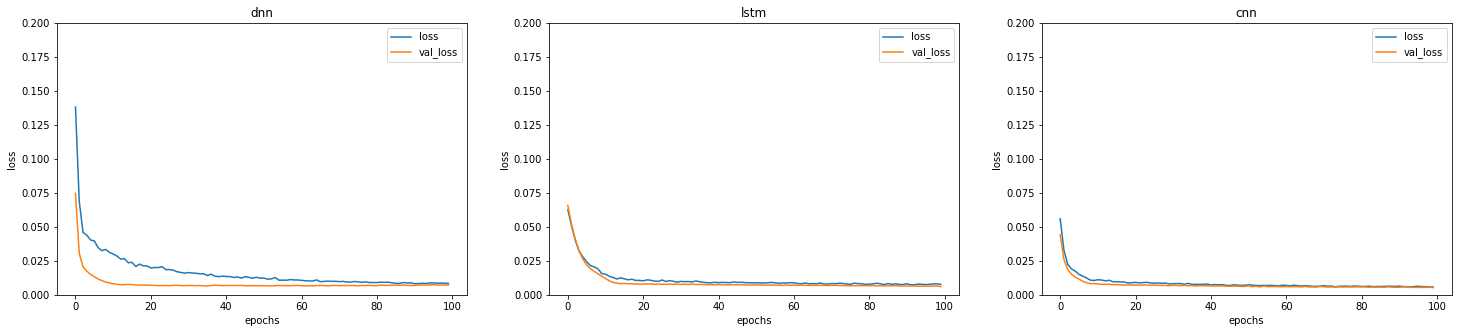

In [25]:
legend = list()

fig, axs = plt.subplots(1, 3, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


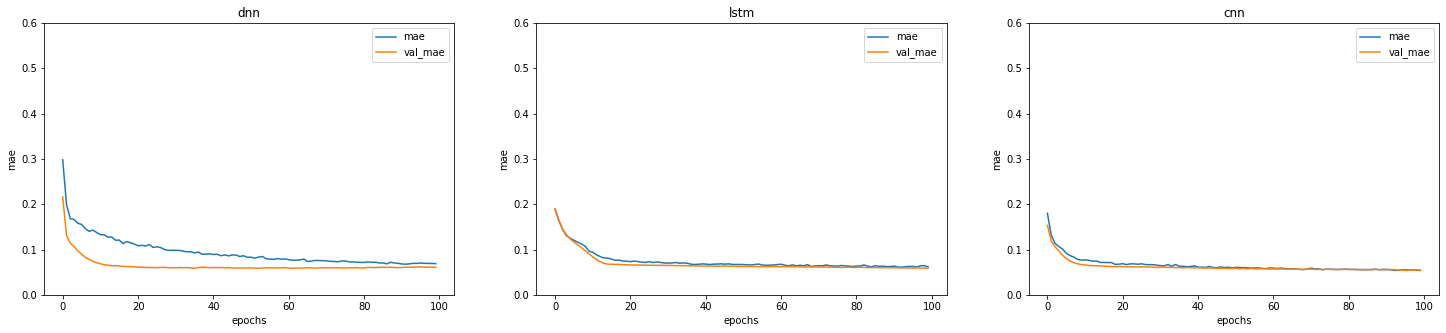

In [26]:
print("MAE Curves")
fig, axs = plt.subplots(1, 3, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)

In [27]:
names = list()
performance = list()

for key, value in model_configs.items():
    names.append(key)
    mae = value['model'].evaluate(value['test_ds'])
    performance.append(mae[1])
    
performance_df = pd.DataFrame(performance, index=names, columns=['mae'])
performance_df['error_mw'] = performance_df['mae'] * df['Monthly Mean Total Sunspot Number'].mean()
print(performance_df)   

5/5 [==============================] - 0s 10ms/step - loss: 0.0043 - mae: 0.0476
           mae  error_mw
dnn   0.052581  4.336917
lstm  0.053688  4.428223
cnn   0.047619  3.927669


The **cnn** performs  best on this task.


Yet **dnn** although quite simple but reveals to be very efficient for this task.
simple approachs can be sometimes just very uselfull
